In [2]:
import time
import random
import os
import mxnet as mx
import numpy as np
from mxnet import gluon, autograd ,nd
#np.set_printoptions(precision=2)
from PIL import Image

from mxnet.gluon import nn, Block, HybridBlock, Parameter, ParameterDict
import mxnet.ndarray as F

from tqdm import tqdm
import utils

### gpu 사용 여부를 지정

In [3]:
ctx = mx.gpu()

In [4]:
os.getcwd()

'/home/seunghwan_2/kmu-tutorial'

### Hyper parameter 정의
 - 이미지 파일 위치 정보 지정 
 - content/style image size 지정
 - content/style weight 설정
    - 둘 중 높은 쪽에 더 가중치를 두어서 학습이 이루어짐
- num_iteration : 총 iteration 횟수

In [5]:
content_image_path = os.getcwd()+'/images/eva.jpg'
style_image_path = os.getcwd() + '/images/picasso.jpg'
output_image_path = os.getcwd() + '/output2.jpg'
content_size = 100
style_size = 100
lr = 1e1
content_weight = 10.0
style_weight = 1000.0
num_iteration = 500

In [6]:
def load_rgbimage(filename, ctx, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1).astype(float)
    img = F.expand_dims(mx.nd.array(img, ctx=ctx), 0)
    return img

In [7]:
##image data loading..
content_image = load_rgbimage(content_image_path,ctx, size=content_size, keep_asp=True)
style_image = load_rgbimage(style_image_path, ctx, size=style_size)

In [8]:
content_image.shape

(1, 3, 141, 100)

In [9]:
style_image.shape

(1, 3, 100, 100)

### pre-trained 네트워크 loading
- VGG16 네트워크를 loading 
- pretrained=True 는 학습된 네트워크의 weight 값을 가지고 오는 것임

In [10]:
vgg_layers = mx.gluon.model_zoo.vision.vgg16(pretrained=True).features

In [11]:
vgg_layers

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Activation(relu)
  (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Activation(relu)
  (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Activation(relu)
  (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Activation(relu)
  (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Activation(relu)
  (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Activation(relu)
  (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Activation(relu)
  (16): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (17): Conv2D(256 -> 512, kernel_size=(

### style 학습을 위한 network를 정의
- 우리가 필요한 부분은 3, 8, 15, 22, 29 번째 layer이기 때문에 해당 부분만 추출하여 network를 생성함

In [12]:
class LossNetwork(gluon.Block):
    def __init__(self,**kwargs):
        super(LossNetwork,self).__init__(**kwargs)
        with self.name_scope():
            self.vgg_layers = mx.gluon.model_zoo.vision.vgg16(pretrained=True).features
            self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3",
            '29': "relu5_3",  
        }
    
    def forward(self,x):
        output ={}
        output = []
        for i in range(31):
            #print(i)
            x = self.vgg_layers[i](x)
            if str(i) in self.layer_name_mapping:
                output.append(x)
        return output

### gram matrix 정의
- loss를 정의하기 위해 도입한 matrix 형태
- 원래의 이미지를 channel 관점에서 dot product를 수행함 -> 최종 형태는 ch X ch
- channel관의 관계를 표현한 matrix 형태로 이해할 수 있음

In [13]:
def gram_matrix(y):
    (b, ch, h, w) = y.shape
    features = y.reshape((b, ch, w * h))
    #features_t = F.SwapAxis(features,1, 2)
    gram = F.batch_dot(features, features, transpose_b=True) / (ch * h * w)
    return gram

In [14]:
a =nd.arange(2*3*4*5).reshape((2,3,4,5))

In [15]:
b = gram_matrix(a)

In [16]:
b.shape

(2, 3, 3)

In [17]:
# load the pre-trained vgg-16 and extract features
vgg = LossNetwork()

In [18]:
#network를 GPU에 강제 할당
vgg.collect_params().initialize(ctx=ctx,force_reinit=True)

In [19]:
# content feature
f_xc_c = vgg(content_image)[3]
# style feature
features_style = vgg(style_image)
gram_style = [gram_matrix(y) for y in features_style]
# output
output = Parameter('output', shape=content_image.shape)
output.initialize(ctx=ctx)
output.set_data(content_image.copy())
# optimizer
trainer = gluon.Trainer([output], 'adam', {'learning_rate': lr})
mse_loss = gluon.loss.L2Loss()

In [20]:
len(vgg(content_image))

5

In [21]:
output.data()


[[[[32. 30. 29. ...  9. 15. 13.]
   [28. 28. 28. ... 11. 12. 11.]
   [30. 28. 29. ... 10. 12. 12.]
   ...
   [25. 29. 24. ... 18. 19. 19.]
   [27. 27. 23. ... 20. 20. 19.]
   [31. 24. 27. ... 20. 22. 20.]]

  [[32. 30. 29. ... 13. 20. 17.]
   [29. 29. 29. ... 14. 15. 14.]
   [31. 30. 29. ... 14. 14. 15.]
   ...
   [33. 35. 30. ... 29. 29. 29.]
   [34. 32. 29. ... 31. 31. 29.]
   [39. 30. 33. ... 30. 34. 30.]]

  [[56. 54. 54. ... 13. 23. 19.]
   [56. 56. 54. ... 15. 15. 13.]
   [57. 57. 55. ... 15. 14. 15.]
   ...
   [60. 63. 54. ... 59. 59. 60.]
   [58. 57. 54. ... 61. 61. 59.]
   [61. 53. 56. ... 61. 66. 57.]]]]
<NDArray 1x3x141x100 @gpu(0)>

In [22]:
features_y = vgg(output.data())

In [23]:
features_y[0].shape

(1, 64, 141, 100)

In [24]:
iter_loss = dict()
iter_loss['style'] =[]
iter_loss['content'] =[]

# optimizing the images
for e in tqdm(range(num_iteration)):
    # fix BN for pre-trained vgg
    with autograd.record():
        features_y = vgg(output.data())
        content_loss = 2 * content_weight * mse_loss(features_y[3], f_xc_c)
        style_loss = 0.
        for m in range(len(features_y)):
            #gram_y = net.gram_matrix(features_y[m])
            gram_y = gram_matrix(features_y[m])
            gram_s = gram_style[m]
            style_loss = style_loss + 2 * style_weight * mse_loss(gram_y, gram_s)
        total_loss = content_loss + style_loss
        total_loss.backward()
    if (e + 1) % 10 == 0:
        iter_loss['style'].append(style_loss.asscalar())
        iter_loss['content'].append(content_loss.asscalar())
        
    
    trainer.step(1)
    #if (e + 1) % 50 == 0:
    #    print('loss:{:.2f}'.format(total_loss.asnumpy()[0]))

100%|██████████| 500/500 [00:10<00:00, 45.91it/s]


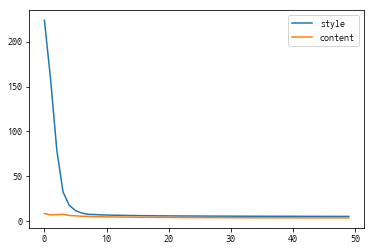

In [25]:
#style/transfer loss plot
import pandas as pd
import matplotlib as mpl
%matplotlib inline 
#pd.options.display.mpl_style = 'default'
new_style = {'grid': False}
mpl.rc('axes', **new_style)
data = pd.DataFrame.from_dict(iter_loss)
data.plot()

In [26]:
#conv_data = utils.add_imagenet_mean_batch(output.data())
conv_data = output.data()

In [27]:
conv_data.shape

(1, 3, 141, 100)

In [28]:
def show_image_rgb(data):
    (r, g, b) = nd.split(data[0], num_outputs=3, axis=0)
    img = F.concat(r, g, b, dim=0)
    img = F.clip(img, 0, 255).asnumpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    return img

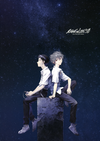

In [29]:
#show original image
show_image_rgb(content_image)

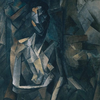

In [31]:
#show style image
show_image_rgb(style_image)

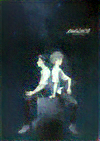

In [32]:
#show changed image
show_image_rgb(conv_data)